<a href="https://colab.research.google.com/github/edenau/maps/blob/master/map_overlay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Update folium for ImageOverlay function

!pip install folium==0.7.0

    100% |████████████████████████████████| 92kB 5.7MB/s 
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.7.0 which is incompatible.
  Found existing installation: folium 0.2.1
    Uninstalling folium-0.2.1:
      Successfully uninstalled folium-0.2.1


In [0]:
# Import

import folium
from folium.plugins import MarkerCluster

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb
import scipy.ndimage.filters

In [0]:
# Mount Google Drive locally

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Data manipulation (from map-density.ipynb)

# Load journey data

f = "/content/gdrive/My Drive/Colab Notebooks/folium/journeys.csv"
j = pd.read_csv(f)

date = j['day'].values
month = j['month'].values
year = j['year'].values
hour = j['hour'].values
minute = j['min'].values
station_start = j['id_start'].values
station_end = j['id_end'].values

# Extract weekday rows

weekday = np.zeros(len(date))
weekday[:] = np.nan
cnt = 0

for _year, _month, _date, _hour, _minute in zip(year, month, date, hour, minute):
  _dt = dt.datetime(_year, _month, _date, _hour, _minute)
  _weekday = _dt.weekday()
  weekday[cnt] = _weekday
  cnt += 1

IsWeekday = weekday < 5
j['IsWeekday'] = IsWeekday

j['TimeSlice'] = (hour*3 + np.floor(minute/20)).astype(int)

# Load Station Data

f = "/content/gdrive/My Drive/Colab Notebooks/folium/stations.csv"
stations = pd.read_csv(f)
station_id = stations['station_id'].values
stations = stations.set_index('station_id')

# Extract valid rows

valid = np.zeros(len(date))
valid[:] = False
cnt = 0

for _start, _end in zip(station_start, station_end):
  if np.logical_and((_start in station_id), (_end in station_id)):
    valid[cnt] = True
  cnt += 1

j['Valid'] = valid

# See how many journeys are valid and on weekdays

df = j[j["IsWeekday"] == True].drop(columns="IsWeekday")
df = df[df["Valid"] == True].drop(columns="Valid")

# Clean data

df = df.loc[:, ['TimeSlice', 'id_start', 'id_end', 'duration']]
df

,TimeSlice,id_start,id_end,duration
0,52,251,478,2040.0
1,44,550,122,1800.0
2,50,212,639,1140.0
3,36,163,755,420.0
4,57,36,605,1200.0
5,43,589,514,1320.0
8,40,153,367,540.0
9,47,396,350,960.0
10,26,732,298,420.0
11,51,818,796,1620.0


In [0]:
# Line drawing functions (from https://github.com/vincentropy/python_cartography_tutorial)

def get_kernel(kernel_size, blur=1/20, halo=.001):
    """
    Create an (n*2+1)x(n*2+1) numpy array.
    Output can be used as the kernel for convolution.
    """
    
    # generate x and y grids
    x, y = np.mgrid[0:kernel_size*2+1, 0:kernel_size*2+1]
    
    center = kernel_size + 1  # center pixel
    r = np.sqrt((x - center)**2 + (y - center)**2)  # distance from center
    
    # now compute the kernel. This function is a bit arbitrary. 
    # adjust this to get the effect you want.
    kernel = np.exp(-r/kernel_size/blur) + (1 - r/r[center,0]).clip(0)*halo
    return kernel

def add_lines(image_array, xys, width=1, weights=None):
    """
    Add a set of lines (xys) to an existing image_array
    width: width of lines
    weights: [], optional list of multipliers for lines. 
    """
    
    for i, xy in enumerate(xys):  # loop over lines
        # create a new gray scale image
        image = Image.new("L",(image_array.shape[1], image_array.shape[0]))
        
        # draw the line
        ImageDraw.Draw(image).line(xy, 200, width=width)
        
        #convert to array
        new_image_array = np.asarray(image, dtype=np.uint8).astype(float)
        
        # apply weights if provided
        if weights is not None:
            new_image_array *= weights[i]
            
        # add to existing array
        image_array += new_image_array

    # convolve image
    new_image_array = scipy.ndimage.filters.convolve(image_array, get_kernel(width*4)) 
    return new_image_array

def to_image(array, hue=.62):
    """converts an array of floats to an array of RGB values using a colormap"""
    
    # apply saturation function
    image_data = np.log(array + 1)
    
    # create colormap, change these values to adjust to look of your plot
    saturation_values = [[0, 0], [1, .68], [.78, .87], [0, 1]]
    colors = [hsv_to_rgb([hue, x, y]) for x, y in saturation_values]
    cmap = LinearSegmentedColormap.from_list("my_colormap", colors)
    
    # apply colormap
    out = cmap(image_data/image_data.max())
    
    # convert to 8-bit unsigned integer
    out = (out*255).astype(np.uint8)
    return out

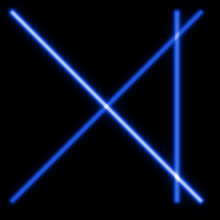

In [0]:
# Test line drawing

xys = [(10,10,200,200), (175,10,175,200), (200,10,10,200)]  # some lines
weights = np.array([ 2,1,.7])/100  # some weights

# create the image_data
new_image_data = add_lines(np.zeros((220,220)),
                           xys,
                           width=4,
                           weights=weights) 


# show the image
Image.fromarray(to_image(new_image_data),mode="RGBA")

In [0]:
# Try only morning data

# Select morning peak hours
# Journeys depart between 0820 and 0859
df_t25 = df[df["TimeSlice"] == 25]
df_t26 = df[df["TimeSlice"] == 26]
df_morning = df_t25.append(df_t26)

# Add additional columns to match with the requirements of pre-defined line drawing functions

df_morning["Start Station Latitude"] = stations.loc[df_morning["id_start"], 'lat'].values
df_morning["Start Station Longitude"] = stations.loc[df_morning["id_start"], 'lon'].values
df_morning["End Station Latitude"] = stations.loc[df_morning["id_end"], 'lat'].values
df_morning["End Station Longitude"] = stations.loc[df_morning["id_end"], 'lon'].values

df_morning

,TimeSlice,id_start,id_end,duration,Start Station Latitude,Start Station Longitude,End Station Latitude,End Station Longitude
28,25,224,368,900.0,51.514769,-0.188129,51.500241,-0.159340
29,25,307,368,660.0,51.509908,-0.187842,51.500241,-0.159340
53,25,273,130,1080.0,51.506133,-0.114686,51.509506,-0.075459
55,25,273,130,1140.0,51.506133,-0.114686,51.509506,-0.075459
142,25,225,400,1140.0,51.509353,-0.196422,51.517703,-0.154106
146,25,234,197,1260.0,51.534504,-0.106992,51.505569,-0.111606
226,25,57,327,960.0,51.523346,-0.120202,51.530950,-0.085603
236,25,70,3,600.0,51.531360,-0.117069,51.521283,-0.084605
307,25,322,298,780.0,51.526293,-0.073955,51.502279,-0.074189
308,25,322,298,780.0,51.526293,-0.073955,51.502279,-0.074189


In [0]:
# Line drawing functions (cont'd) (from https://github.com/vincentropy/python_cartography_tutorial)


min_lat = stations["lat"].min()
max_lat = stations["lat"].max()
max_lon = stations["lon"].max()
min_lon = stations["lon"].min()

def latlon_to_pixel(lat, lon, image_shape):
    # longitude to pixel conversion (fit data to image)
    delta_x = image_shape[1]/(max_lon-min_lon)
    
    # latitude to pixel conversion (maintain aspect ratio)
    delta_y = delta_x/np.cos(lat/360*np.pi*2)
    pixel_y = (max_lat-lat)*delta_y
    pixel_x = (lon-min_lon)*delta_x
    return (pixel_y,pixel_x)


def row_to_pixel(row,image_shape):
    """
    convert a row (1 trip) to pixel coordinates
    of start and end point
    """
    start_y, start_x = latlon_to_pixel(row["Start Station Latitude"], 
                                       row["Start Station Longitude"], image_shape)
    end_y, end_x = latlon_to_pixel(row["End Station Latitude"], 
                                   row["End Station Longitude"], image_shape)
    xy = (start_x, start_y, end_x, end_y)
    return xy

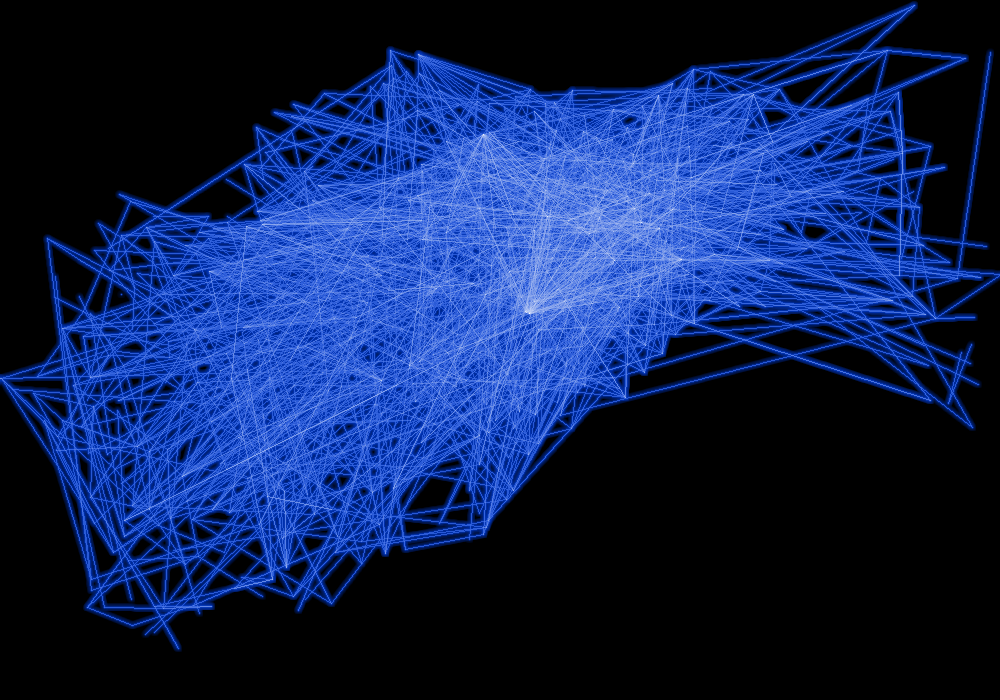

In [0]:
# Draw paths with black background

paths = df_morning
paths = paths.iloc[:3000,:]

# generate empty pixel array, choose your resolution
image_data = np.zeros((700,1000))

# generate pixel coordinates of starting points and end points
xys = [row_to_pixel(row, image_data.shape) for i, row in paths.iterrows()]

# draw the lines
image_data = add_lines(image_data, xys, weights=None, width = 1)
Image.fromarray(to_image(image_data*10)[:,:,:3],mode="RGB")

In [0]:
# Group and count paths by (id_start, id_end) tuple

# make a list of locations (latitude longitude) for each station id
locations = df_morning.groupby("id_start").mean()
locations = locations.loc[:,["Start Station Latitude", "Start Station Longitude"]]

# group by each unique pair of (start-station, end-station) and count the number of trips
df_morning["path_id"] = [(id1,id2) for id1,id2 in zip(df_morning["id_start"], 
                                                      df_morning["id_end"])]
paths = df_morning.groupby("path_id").count().iloc[:,[1]] 
paths.columns = ["Trip Count"]

# select only paths with more than X trips
paths = paths[paths["Trip Count"]>5]
paths["Start Station ID"] = paths.index.map(lambda x:x[0])
paths["End Station ID"] = paths.index.map(lambda x:x[1])
paths = paths[paths["Start Station ID"]!=paths["End Station ID"]]

# join latitude/longitude into new table
paths = paths.join(locations,on="Start Station ID")
locations.columns = ["End Station Latitude","End Station Longitude"]
paths = paths.join(locations,on="End Station ID")
paths.index = range(len(paths))

paths.shape

(4121, 7)

In [0]:
# Cont'd

def get_image_data(paths, min_count=0, max_count=None):
    # generate empty pixel array
    image_data = np.zeros((900*2,400*2))
    
    # generate pixel coordinates of starting points and end points
    if max_count is None:
        max_count = paths["Trip Count"].max()+1
    selector = (paths["Trip Count"]>= min_count) & (paths["Trip Count"]< max_count)
    xys = [row_to_pixel(row, image_data.shape) for i, row in paths[selector].iterrows()]

    # draw the lines
    image_data = add_lines(image_data, xys, weights=paths["Trip Count"], width = 1)
    return image_data

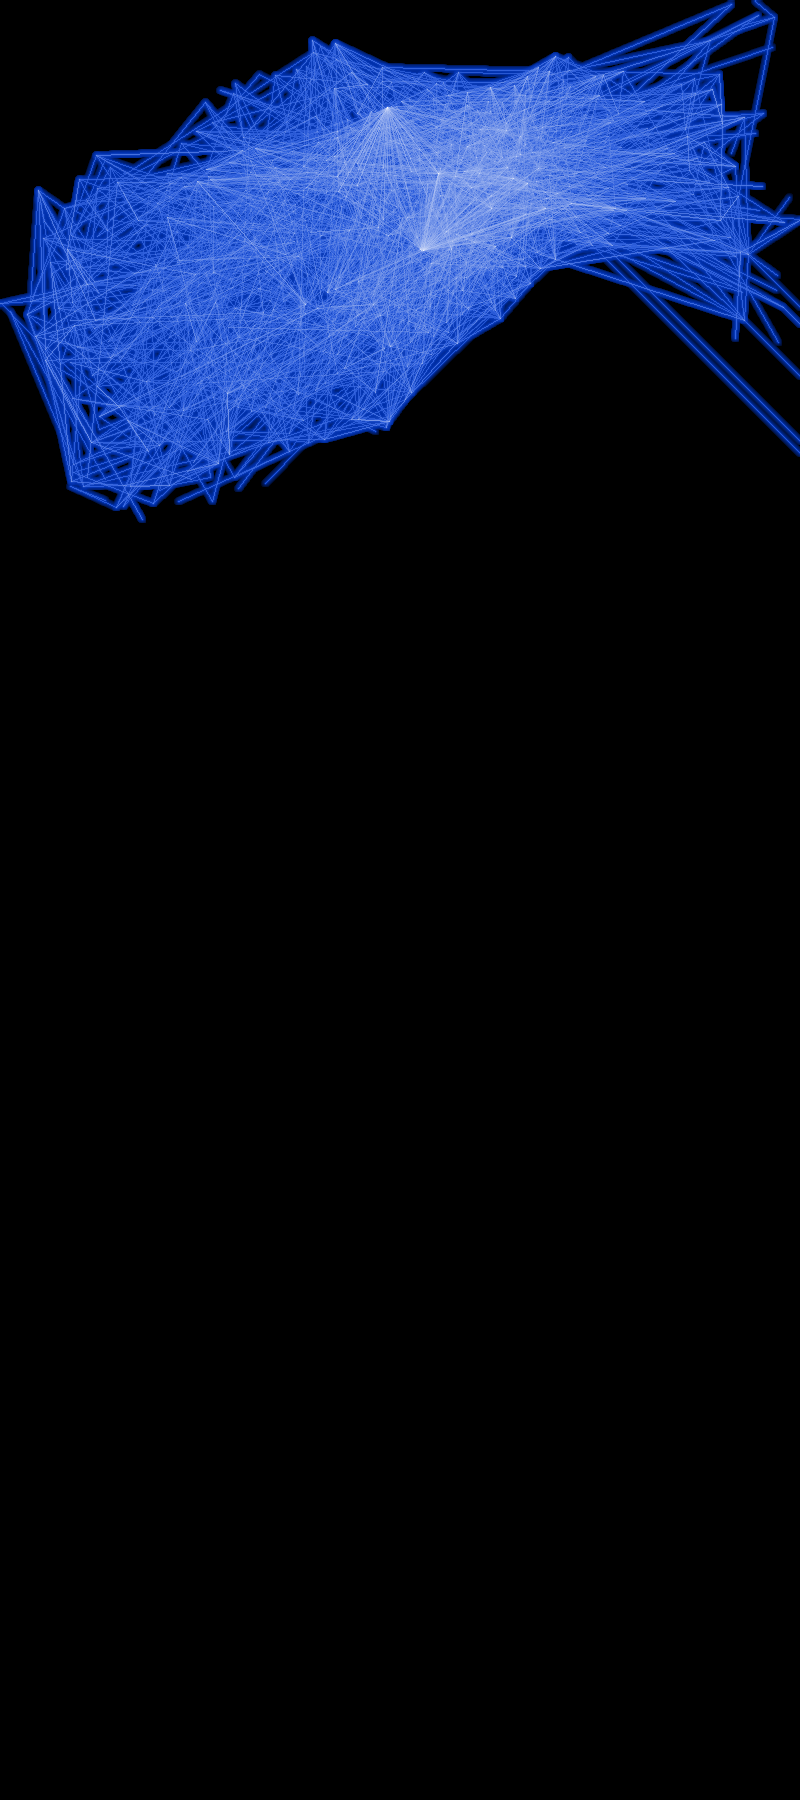

In [0]:
# Try drawing

Image.fromarray(to_image(get_image_data(paths)*10)[:,:,:3],mode="RGB")

In [0]:
# Make it glow! (from https://github.com/vincentropy/python_cartography_tutorial)

def add_alpha(image_data):
    """
    Uses the Value in HSV as an alpha channel. 
    This creates an image that blends nicely with a black background.
    """
    
    # get hsv image
    hsv = rgb_to_hsv(image_data[:,:,:3].astype(float)/255)
    
    # create new image and set alpha channel
    new_image_data = np.zeros(image_data.shape)
    new_image_data[:,:,3] = hsv[:,:,2]
    
    # set value of hsv image to either 0 or 1.
    hsv[:,:,2] = np.where(hsv[:,:,2]>0, 1, 0)
    
    # combine alpha and new rgb
    new_image_data[:,:,:3] = hsv_to_rgb(hsv)
    return new_image_data

In [0]:
# Create the map

London = [51.506949, -0.122876]
folium_map_static = folium.Map(location=London,
                        zoom_start=12,
                        tiles="CartoDB dark_matter",
                        width='100%')

# create the overlay
map_overlay = add_alpha(to_image(image_data*10))

# compute extent of image in lat/lon
aspect_ratio = map_overlay.shape[1]/map_overlay.shape[0]
delta_lat = (max_lon-min_lon)/aspect_ratio*np.cos(min_lat/360*2*np.pi)

# add the image to the map
img = folium.raster_layers.ImageOverlay(map_overlay,
                           bounds = [(max_lat-delta_lat,min_lon),(max_lat,max_lon)],
                           opacity = 0.8,
                           name = 'paths')

img.add_to(folium_map_static)
folium.LayerControl().add_to(folium_map_static)

# show the map
folium_map_static

In [0]:
# Use LayerControl for multiple layers of graphs

folium_map = folium.Map(location=London,
                        zoom_start=12,
                        tiles="CartoDB dark_matter",
                        width='100%')

thresholds = [5,10,15,20,25,30]

for i,t in enumerate(thresholds):
    upper = thresholds[i+1] if i<len(thresholds)-1 else None
    image_data = get_image_data(paths, t, upper)
    name = "{} <= # trip < {}".format(t,"max" if upper is None else upper)

    map_overlay = add_alpha(to_image(image_data*10))
    delta_lat = (max_lon-min_lon)/map_overlay.shape[1]*map_overlay.shape[0]*np.cos(min_lat/360*2*np.pi)
    img = folium.raster_layers.ImageOverlay(map_overlay,
                                            bounds = [(max_lat-delta_lat,min_lon),(max_lat,max_lon)], 
                                            name = name,
                                            opacity = 0.8)

    img.add_to(folium_map)

lc = folium.LayerControl().add_to(folium_map)

folium_map

In [0]:
# Save the map

f = "/content/gdrive/My Drive/Colab Notebooks/folium/map_morning_overlay_static.html"
folium_map_static.save(f)

f = "/content/gdrive/My Drive/Colab Notebooks/folium/map_morning_overlay.html"
folium_map.save(f)